# Подготовка данных

In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.8 MB/s eta 0:00:00


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.9 MB/s eta 0:00:00


In [3]:
from tqdm.auto import tqdm  # for showing progress bar

# функция добавляем индекс конца ответа
def add_end_idx(answers, contexts):
    new_answers = []
    # loop through each answer-context pair
    for answer, context in tqdm(zip(answers, contexts)):
        # quick reformating to remove lists
        answer['text'] = answer['text'][0]
        answer['answer_start'] = answer['answer_start'][0]
        # gold_text refers to the answer we are expecting to find in context
        gold_text = answer['text']
        # we already know the start index
        start_idx = answer['answer_start']
        # and ideally this would be the end index...
        end_idx = start_idx + len(gold_text)

        # ...however, sometimes squad answers are off by a character or two
        if context[start_idx:end_idx] == gold_text:
            # if the answer is not off :)
            answer['answer_end'] = end_idx
        else:
            # this means the answer is off by 1-2 tokens
            for n in [1, 2]:
                if context[start_idx-n:end_idx-n] == gold_text:
                    answer['answer_start'] = start_idx - n
                    answer['answer_end'] = end_idx - n
        new_answers.append(answer)
    return new_answers

#возвращет словарь в требуемом формате
def prep_data(dataset):
    questions = dataset['question']
    contexts = dataset['context']
    answers = add_end_idx(
        dataset['answers'],
        contexts
    )
    return {
        'question': questions,
        'context': contexts,
        'answers': answers
    }

In [4]:
import pandas as pd
df = pd.read_excel("data_train.xlsx", index_col=None)

In [5]:
df_test = pd.read_excel("data_test.xlsx", index_col=None)

In [6]:
df_tr = df
df_eval = df_test

In [7]:
answer_texts_tr = df_tr['answer_text'].tolist()
answer_starts_tr = df_tr['answer_start'].tolist()

answer_texts_eval = df_eval['answer_text'].tolist()
answer_starts_eval = df_eval['answer_start'].tolist()

In [8]:
answers_tr = []
for text, start in zip(answer_texts_tr, answer_starts_tr):
    answers_tr.append({'text': [text], 'answer_start': [start]})

answers_eval = []
for text, start in zip(answer_texts_eval, answer_starts_eval):
    answers_eval.append({'text': [text], 'answer_start': [start]})

In [9]:
import uuid

id_array_tr = []
titles_tr = []

for elem in answer_starts_tr:
    x = uuid.uuid4()
    x = str(x)
    id_array_tr.append(x)
    titles_tr.append("My_dataset_train")

id_array_eval = []
titles_eval = []

for elem in answer_starts_eval:
    x = uuid.uuid4()
    x = str(x)
    id_array_eval.append(x)
    titles_eval.append("My_dataset_eval")


Здесь мы получаем датасет в формате <a href="https://huggingface.co/datasets/squad">squad</a>.

In [10]:
data_tr = {}
data_tr['context'] = df_tr['context'].tolist()
data_tr['question'] = df_tr['question'].tolist()
data_tr['answers'] = answers_tr
data_tr['id'] = id_array_tr
data_tr['title'] = titles_tr

data_eval = {}
data_eval['context'] = df_eval['context'].tolist()
data_eval['question'] = df_eval['question'].tolist()
data_eval['answers'] = answers_eval
data_eval['id'] = id_array_eval
data_eval['title'] = titles_eval

In [11]:
print(data_tr['question'][3], '\n', data_tr['answers'][3])

 What does USER_NOT_PAID mean? 
 {'text': ['The customer has not paid for the order (for the PREPAID payment type) within 30 minutes.'], 'answer_start': [793]}


In [ ]:
data_eval['answers'][3]

{'text': ['Creates an Authorizer for an API.'], 'answer_start': [167]}

In [ ]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

dd_tr = Dataset.from_dict(data_tr)
dd_eval = Dataset.from_dict(data_eval)

In [ ]:
data_eval['question']

['DeleteRouteRequestParameter',
 'CreateVpcLink',
 'CreateDomainName',
 'CreateAuthorizer',
 'DeleteCorsConfiguration',
 'Action',
 'OrganizationId',
 'Principal',
 'StatementId',
 'The API action that grants access to the layer.',
 'With the principal set to *, grant permission to all accounts in the specified organization.',
 'An account ID, or * to grant layer usage permission to all accounts in an organization, or all AWS accounts (if organizationId is not specified).',
 'StatementId Type',
 'StatementId Length Constraints',
 'InvalidParameterValueException',
 'PolicyLengthExceededException',
 'PreconditionFailedException',
 'ResourceConflictException',
 'ResourceNotFoundException',
 'ServiceException',
 'TooManyRequestsException',
 'One of the parameters in the request is not valid.',
 'The permissions policy for the resource is too large.']

In [12]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

#Обучение

##model_checkpoint = "distilbert-base-cased-distilled-squad"

In [ ]:
model_checkpoint = "distilbert-base-cased-distilled-squad"

max_length = 512 # The maximum length of a feature (question and context)
doc_stride = 256

In [ ]:
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
pad_on_right = tokenizer.padding_side == "right"

In [ ]:
features_tr = prepare_train_features(data_tr)
tokenized_datasets_tr = dd_tr.map(prepare_train_features, batched=True, remove_columns=dd_tr.column_names)

features_eval = prepare_train_features(data_eval)
tokenized_datasets_eval = dd_eval.map(prepare_train_features, batched=True, remove_columns=dd_eval.column_names)

Map:   0%|          | 0/122 [00:00<?, ? examples/s]

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

In [ ]:
#from huggingface_hub import notebook_login
#notebook_login()

In [ ]:
from transformers import default_data_collator

data_collator = default_data_collator

In [ ]:
batch_size = 16
lr = 1e-7
epochs = 10

In [ ]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"distilbert-finetuned-lr{lr}-epochs{epochs}",
    evaluation_strategy = "epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.01,
    push_to_hub=True,
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets_tr,
    eval_dataset=tokenized_datasets_eval,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

Cloning https://huggingface.co/gallyamovi/distilbert-finetuned-lr1e-07-epochs10 into local empty directory.


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,6.380969
2,No log,6.288508
3,No log,6.211007
4,No log,6.146545
5,No log,6.092518
6,No log,6.053399
7,No log,6.021744
8,No log,5.998969
9,No log,5.986213
10,No log,5.981586


TrainOutput(global_step=100, training_loss=5.681004028320313, metrics={'train_runtime': 83.0442, 'train_samples_per_second': 18.544, 'train_steps_per_second': 1.204, 'total_flos': 201205774049280.0, 'train_loss': 5.681004028320313, 'epoch': 10.0})

In [ ]:
trainer.save_model(model_checkpoint + "_gallyamovi")

Upload file pytorch_model.bin:   0%|          | 1.00/249M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.56k [00:00<?, ?B/s]

Upload file runs/May02_08-52-10_ca960709e516/1683017536.172517/events.out.tfevents.1683017536.ca960709e516.430…

Upload file runs/May02_08-52-10_ca960709e516/events.out.tfevents.1683017536.ca960709e516.430.26:   0%|        …

To https://huggingface.co/gallyamovi/distilbert-finetuned-lr1e-07-epochs10
   9209c82..abb626b  main -> main

   9209c82..abb626b  main -> main

To https://huggingface.co/gallyamovi/distilbert-finetuned-lr1e-07-epochs10
   abb626b..17754e3  main -> main

   abb626b..17754e3  main -> main



In [ ]:
trainer.push_to_hub()

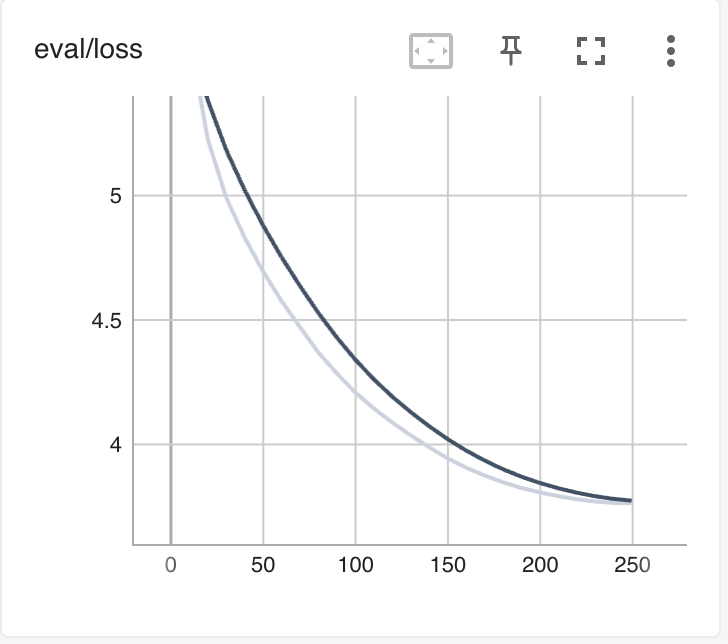

In [69]:
from IPython.display import Image, display
display(Image(filename='1.png'))

#для lr=1e-06 epochs=25
#https://huggingface.co/gallyamovi/distilbert-finetuned-lr1e-06-epochs25/tensorboard

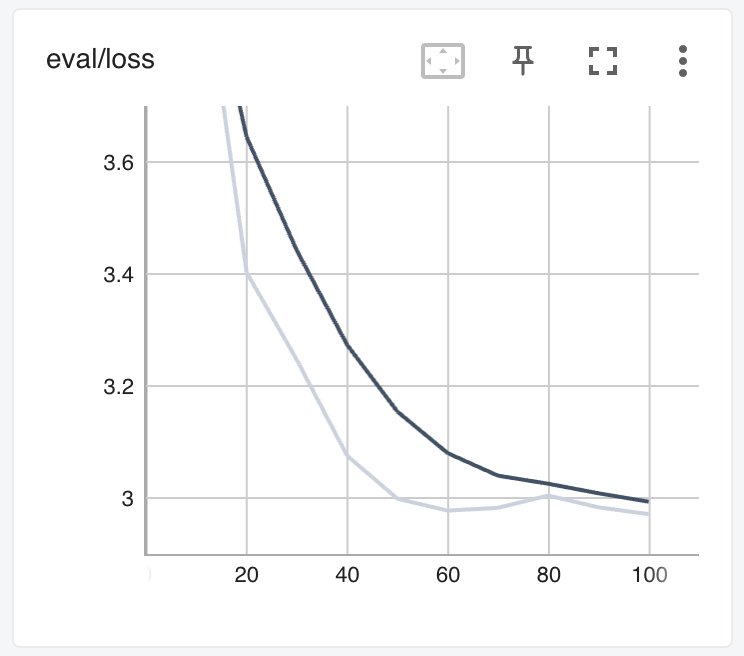

In [68]:
from IPython.display import Image, display
display(Image(filename='2.png'))

#для lr=1e-05 epochs=10
#https://huggingface.co/gallyamovi/distilbert-finetuned-lr1e-05-epochs10/tensorboard

#Примеры

In [ ]:
i = 12
context = df_test['context'][i]
question = df_test['question'][i]
ans = df_test['answer_text'][i]
question, ans

('StatementId Type', 'String')

In [17]:
from transformers import pipeline
model_finetuned = pipeline("question-answering", model='gallyamovi/distilbert-finetuned-lr1e-05-epochs10')
model_basic = pipeline("question-answering", model='distilbert-base-cased-distilled-squad')
for i in range(23):
    context = df_test['context'][i]
    question = df_test['question'][i]
    ans = df_test['answer_text'][i]
    print(i)
    res0 = model_basic(question=question, context=context)
    res1 = model_finetuned(question=question, context=context)
    if res0['answer'] != res1['answer']:
        print('Qusetion:', question)
        print('True answer:', ans)
        print('Ans for model basic:', res0['answer'])
        print('Ans for model finetuned:', res1['answer'])
        print('______________________________________________')



0
Qusetion: DeleteRouteRequestParameter
True answer: Deletes a route request parameter.
Ans for model basic: route request parameter
Ans for model finetuned: Deletes a route request parameter.

DeleteRouteResponse
______________________________________________
1
Qusetion: CreateVpcLink
True answer: Creates a VPC link.
Ans for model basic: VPC link
Ans for model finetuned: Deletes a VPC link.

ExportApi
______________________________________________
2
Qusetion: CreateDomainName
True answer: Creates a domain name.
Ans for model basic: CreateDomainName

Creates a domain name
Ans for model finetuned: CreateIntegration
______________________________________________
3
Qusetion: CreateAuthorizer
True answer: Creates an Authorizer for an API.
Ans for model basic: DeleteAuthorizer

Deletes an Authorizer
Ans for model finetuned: GetApi
______________________________________________
4
Qusetion: DeleteCorsConfiguration
True answer: Deletes a CORS configuration.
Ans for model basic: CORS configurat

# Тесты

## Составляем "нормализатор" текста, пишем метрики.

In [55]:
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return 0, 0, int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0, 0, 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return prec, rec, 2 * (prec * rec) / (prec + rec)

##Получаем результаты:

In [56]:
lr_list = [1e-5, 1e-6, 1e-7]
epochs_list = [10, 15, 25, 50]
res_lr_epoch = {}

In [57]:
def get_results(lr_list, epochs_list):
    for lr in lr_list:
        for epochs in epochs_list:
            prec_list, rec_list, f1_list = [], [], []
            model_name = 'gallyamovi/' + f"distilbert-finetuned-lr{lr}-epochs{epochs}"
            model_finetuned = pipeline("question-answering", model=model_name)
            for i in range(23):
                context = df_test['context'][i]
                question = df_test['question'][i]
                truth = df_test['answer_text'][i]
                result = model_finetuned(question=question, context=context)
                prediction = result['answer']
                prec, rec, f1 = compute_f1(prediction, truth)
                prec_list.append(prec)
                rec_list.append(rec)
                f1_list.append(f1)
            average_prec = sum(prec_list) / len(prec_list)
            average_rec = sum(rec_list) / len(rec_list)
            average_f1 = sum(f1_list) / len(f1_list)
            print(f"lr{lr}-epochs{epochs}")
            print('\t prec:', average_prec)
            print('\t rec:', average_rec)
            print('\t f1:', average_f1)
            res_lr_epoch[(lr, epochs)] = (average_prec, average_rec, average_f1)
            



            


In [58]:
get_results(lr_list, epochs_list)

lr1e-05-epochs10
	 prec: 0.6632332643202209
	 rec: 0.47526821005081865
	 f1: 0.47552829443188616
lr1e-05-epochs15
	 prec: 0.628088336783989
	 rec: 0.529874835309618
	 f1: 0.5221012485563277
lr1e-05-epochs25
	 prec: 0.7063492063492064
	 rec: 0.6023386034255599
	 f1: 0.5955312002471489
lr1e-05-epochs50
	 prec: 0.6411318150448586
	 rec: 0.500889328063241
	 f1: 0.5054690884459067
lr1e-06-epochs10
	 prec: 0.5
	 rec: 0.4999670619235837
	 f1: 0.46847802666216987
lr1e-06-epochs15
	 prec: 0.5434782608695652
	 rec: 0.5336627140974967
	 f1: 0.49492536449058183
lr1e-06-epochs25
	 prec: 0.5760869565217391
	 rec: 0.5369565217391304
	 f1: 0.5072442050702921
lr1e-06-epochs50
	 prec: 0.6125603864734299
	 rec: 0.4439958592132505
	 f1: 0.43074630683326337
lr1e-07-epochs10
	 prec: 0.5815217391304348
	 rec: 0.5615612648221344
	 f1: 0.537180580147332
lr1e-07-epochs15
	 prec: 0.5815217391304348
	 rec: 0.5615612648221344
	 f1: 0.537180580147332
lr1e-07-epochs25
	 prec: 0.5905797101449276
	 rec: 0.557938076416

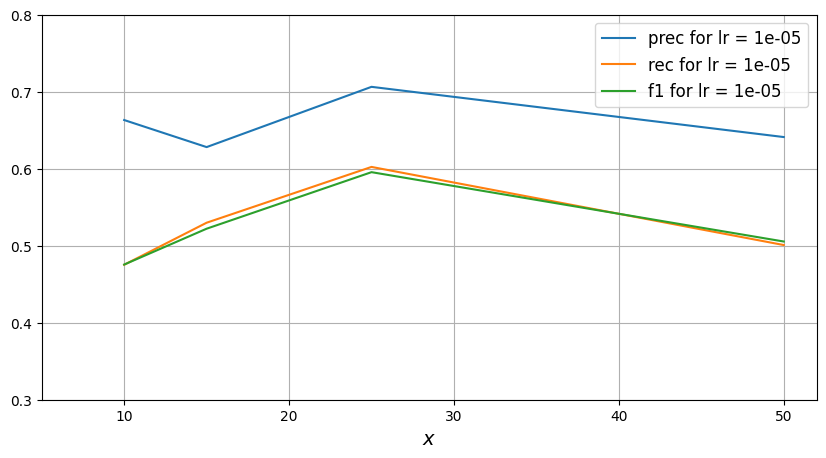

In [60]:
import numpy as np
import matplotlib.pyplot as plt
lr = 1e-05
x = [10, 15, 25, 50]
prec = [res_lr_epoch[(lr, i)][0] for i in x]
rec = [res_lr_epoch[(lr, i)][1] for i in x]
f1 = [res_lr_epoch[(lr, i)][2] for i in x]

plt.figure(figsize=(10, 5))
plt.plot(x, prec, label=r'prec for lr = 1e-05')
plt.plot(x, rec, label=r'rec for lr = 1e-05')
plt.plot(x, f1, label=r'f1 for lr = 1e-05')
plt.xlabel(r'$x$', fontsize=14)

plt.grid(True)
plt.xlim([5, 52])
plt.ylim([0.3, 0.8])
plt.legend(loc='best', fontsize=12)
plt.savefig('figure_with_legend.png')
plt.show()

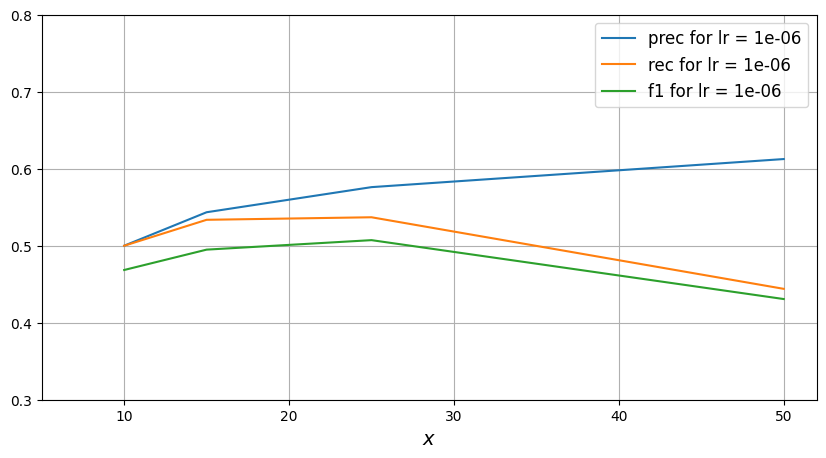

In [61]:
lr = 1e-06
x = [10, 15, 25, 50]
prec = [res_lr_epoch[(lr, i)][0] for i in x]
rec = [res_lr_epoch[(lr, i)][1] for i in x]
f1 = [res_lr_epoch[(lr, i)][2] for i in x]

plt.figure(figsize=(10, 5))
plt.plot(x, prec, label=r'prec for lr = 1e-06')
plt.plot(x, rec, label=r'rec for lr = 1e-06')
plt.plot(x, f1, label=r'f1 for lr = 1e-06')
plt.xlabel(r'$x$', fontsize=14)

plt.grid(True)
plt.xlim([5, 52])
plt.ylim([0.3, 0.8])
plt.legend(loc='best', fontsize=12)
plt.savefig('figure_with_legend.png')
plt.show()

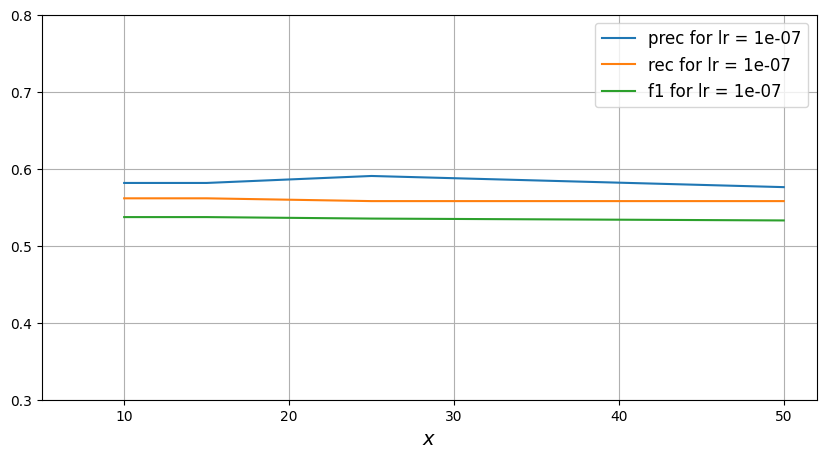

In [62]:
lr = 1e-07
x = [10, 15, 25, 50]
prec = [res_lr_epoch[(lr, i)][0] for i in x]
rec = [res_lr_epoch[(lr, i)][1] for i in x]
f1 = [res_lr_epoch[(lr, i)][2] for i in x]

plt.figure(figsize=(10, 5))
plt.plot(x, prec, label=r'prec for lr = 1e-07')
plt.plot(x, rec, label=r'rec for lr = 1e-07')
plt.plot(x, f1, label=r'f1 for lr = 1e-07')
plt.xlabel(r'$x$', fontsize=14)

plt.grid(True)
plt.xlim([5, 52])
plt.ylim([0.3, 0.8])
plt.legend(loc='best', fontsize=12)
plt.savefig('figure_with_legend.png')
plt.show()

##Причем такие результаты для недообученной модели:

In [ ]:
model_finetuned = pipeline("question-answering", model='distilbert-base-cased-distilled-squad')
prec_list = []
rec_list = []
f1_list = []
for i in range(23):
    context = df_test['context'][i]
    question = df_test['question'][i]
    truth = df_test['answer_text'][i]
    result = model_finetuned(question=question, context=context)
    prediction = result['answer']
    prec, rec, f1 = compute_f1(prediction, truth)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)
average_prec = sum(prec_list) / len(prec_list)
average_rec = sum(rec_list) / len(rec_list)
average_f1 = sum(f1_list) / len(f1_list)
print(average_prec, average_rec, average_f1)

0.5815217391304348 0.5615612648221344 0.537180580147332
